In [ ]:
from google.colab import files
uploaded=files.upload()

Saving base2022_compra.xlsb to base2022_compra.xlsb


In [ ]:
pfrom google.colab import files
uploaded=files.upload()

Saving base2022_venda.xlsb to base2022_venda.xlsb


In [ ]:
!pip install pyxlsb

In [ ]:
!pip install pyxlsb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import statistics
import seaborn as sns
import random

In [ ]:
# knapsack algorithm to get the combinations for each sale
# t - memoization table to keep track of values for each item
# wt - array of weights (quantities for each purchase)
# val - array of values (also quantitied for each purchase)
# W - maximum capacity of the knapsack (quantity of the sale)
# n - number of possible purchases
# items_picked - array to store de purchases chosen
# returns the purchases chosen
def knapsack(t, wt, val, W, n, items_picked):
  value = 0
  for i in range(n + 1):
      for j in range(W + 1):
          if i == 0 or j == 0:
            t[i][j] = 0
          elif wt[i - 1] <= j:
              t[i][j] = max(val[i - 1] + t[i - 1][j - wt[i - 1]], t[i - 1][j]);
              value = t[i][j];
          else: t[i][j] = t[i - 1][j];

  position_at_j = W;
  position_at_i = n;

  value_at = t[position_at_i][position_at_j];

  while value_at != 0:
      if value_at == t[position_at_i-1][position_at_j]:
          position_at_i -= 1
      else:
          items_picked.append(position_at_i-1)
          position_at_i -= 1
          position_at_j = position_at_j - wt[position_at_i];
      value_at = t[position_at_i][position_at_j];
  return items_picked;

In [ ]:
# get possible purchases for each sale and run the knapsack
# dataframe_purchases - the dataframe representing the purchases data
# dataframe_sales - the dataframe representing the sales data
# returns a dataframe representing the combinations found by the knapsack
def get_purchases_for_sales(dataframe_purchases, dataframe_sales):
  combinations = pd.DataFrame()
  for index, sales_row in dataframe_sales.iterrows():
      print(index)
      values = []
      weights = []
      # Filter dataframe_purchases for matching criteria
      filtered_purchases = dataframe_purchases[
          (dataframe_purchases['Cód. Cliente'] == sales_row['Cód. Cliente']) &
          (dataframe_purchases['Dt. Operação'] == sales_row['Dt. Operação']) &
          (dataframe_purchases['Cód. Corretora'] == sales_row['Cód. Corretora']) &
          (dataframe_purchases['Cód. Título'] == sales_row['Cód. Título'])
      ]
      for index, purchases_row in filtered_purchases.iterrows():
        values.append(purchases_row['Quantidade'])
        weights.append(purchases_row['Quantidade'])
      W = sales_row["Quantidade"]
      n = len(values)

      # Initialize the memoization table with -1
      t = [[-1 for i in range(W + 1)] for j in range(n + 1)]

      items_picked = knapsack(t, weights, values, W, n, [])
      if items_picked:
            indices_to_remove = filtered_purchases.iloc[items_picked].index
            selected_rows = filtered_purchases.iloc[items_picked].copy()

            selected_rows["Chave"] = sales_row["Chave"]
            # Calculate price variance
            price_variance = selected_rows['Preço'].var()
            # Aggregate selected rows if more than one
            if len(items_picked) > 1:
                aggregated_rows = selected_rows.groupby(['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Chave']).agg({
                    'Quantidade': 'sum',
                    'Valor Líquido': 'sum',
                    'Preço': 'mean'
                }).reset_index()

                dataframe_purchases = dataframe_purchases.drop(indices_to_remove)

                # Add the calculated price variance to the aggregated rows
                aggregated_rows['Preço Var'] = price_variance

                combinations = pd.concat([combinations, aggregated_rows])
            else:
                combinations = pd.concat([combinations, selected_rows])
  return combinations

In [ ]:
def calculate_profit(dataframe):
  profits = []
  sales_purchases_ratios = []
  for index, combination in dataframe.iterrows():
    ratio = combination["Valor Líquido Venda"] / abs(combination["Valor Líquido Compra"])
    sales_purchases_ratios.append(ratio)
    profit = ratio - 1
    du = abs((combination["Dt. Operação"] - combination["Vencimento"]).days)
    anual_profit = pow((1 + profit), 252 / du) - 1
    cdi_profit = anual_profit / combination["DI"]
    profits.append(cdi_profit*100)
  return profits, sales_purchases_ratios

In [ ]:
df_purchase = pd.read_excel("base2022_compra.xlsb", engine="pyxlsb")


In [ ]:
# change the date columns to pandas datetime
df_purchase_datetime = df_purchase.copy()
df_purchase_datetime['Dt. Operação'] = pd.to_datetime(df_purchase_datetime['Dt. Operação'])
df_purchase_datetime['Dt. Liquidação'] = pd.to_datetime(df_purchase_datetime['Dt. Liquidação'])
df_purchases = pd.concat([df_purchase_datetime], ignore_index=True)
df_purchases = df_purchases.sort_values(by=["Cód. Cliente", "Dt. Operação", "Cód. Título", "Cód. Corretora"]).reset_index()
pd.set_option('display.max_columns', None)



<ipython-input-9-e214f1fef73f>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_purchase_datetime['Dt. Operação'] = pd.to_datetime(df_purchase_datetime['Dt. Operação'])


In [ ]:
df_sales = pd.read_excel("base2022_venda.xlsb", engine="pyxlsb")

In [ ]:
df_sales_datetime = df_sales.copy()
df_sales_datetime['Dt. Operação'] = pd.to_datetime(df_sales_datetime['Dt. Operação'], unit='D', origin='1899-12-30')
df_sales_datetime['Vencimento'] = pd.to_datetime(df_sales_datetime['Vencimento'], unit='D', origin='1899-12-30')
df_sales_datetime = df_sales_datetime.sort_values(by=["Cód. Cliente", "Dt. Operação", "Cód. Título", "Cód. Corretora"]).reset_index()

In [ ]:
n=2000

#split DataFrame into chunks
purchase_chunks = [df_sales_datetime[i:i+n] for i in range(0,len(df_sales_datetime),n)]

In [ ]:
print(len(purchase_chunks))

3


## Casamento de tabelas brutas

Para obter análises estatísticas preliminares de possíveis resultados, decidimos como uma das estratégias apenas obter as compras e vendas que possuem a mesma quantidade (além das outras restrições como cliente, data da operação, corretora e título) a partir dos dados brutos, ou seja, apenas juntando as tabelas iniciais.

Neste, podemos perceber não existem compras e vendas que possuem a mesma quantidade de compras e vendas (além das outras restrições como cliente, data da operação, corretora e título) a a partir dos dados brutos, ou seja, apenas juntando as tabelas iniciais.

In [ ]:
df_same_quantities_brute = pd.merge(df_purchases, df_sales_datetime,
                                 on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Quantidade'],
                                 how='inner')

df_same_quantities_brute.rename(columns={"Valor Líquido_x": "Valor Líquido Compra"}, inplace=True)
df_same_quantities_brute.rename(columns={"Valor Líquido_y": "Valor Líquido Venda"}, inplace=True)

display(df_same_quantities_brute)

,index_x,Cód. Cliente,Dt. Operação,Tipo Operação_x,Cód. Título,Cód. Corretora,Quantidade,Preço_x,Valor Líquido Compra,Dt. Liquidação,Tipo_x,index_y,Chave,Tipo Operação_y,Preço_y,Valor Líquido Venda,Vencimento,Tipo_y,DI


In [ ]:
profits_brute, ratios_brute = calculate_profit(df_same_quantities_brute)
print(profits_brute)
print(ratios_brute)

[]
[]


#Geração de soluções possíveis utilizando o método da mochila

Outra estratégia foi criar combinações utilizando o problema da mochila, que consiste em escolher items para colocar na mochila que maximizem seu valor, mas não ultrapassem seu limite de peso. No caso, tanto os pesos quanto os valores são as quantidades de cada compra e a capacidade máxima é a quantidade da venda. Assim, compras são escolhidas para uma certa venda, gerando uma combinação.

Foram gerados 3 experimentos com partes da tabela de vendas (2000 linhas cada) para comparar os resultados finais.

##Experimento 1

In [ ]:
temp_df_purchases = df_purchases.copy(deep=True)
combinations_purchases = get_purchases_for_sales(temp_df_purchases, purchase_chunks[0])
display(combinations_purchases)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Quantidade,Valor Líquido,Preço,Preço Var
0,Cliente 10,2022-02-02,TERR,BRAP4,B164,9530,-237726.686810,24.973807,0.436341
0,Cliente 10,2022-02-02,CSUI,CESP6,B288,5023,-110949.048949,22.030868,0.465071
0,Cliente 10,2022-02-02,TERR,CSRN6,B382,21712,-340091.182488,15.642173,0.161521
0,Cliente 10,2022-02-02,SAFR,SOMA3,B1066,13754,-169961.776133,12.366046,0.046852
0,Cliente 10,2022-02-14,TERR,APTI4,B53,74,-235777.694209,3188.868082,5198.498337
...,...,...,...,...,...,...,...,...,...
0,Cliente 100,2022-08-15,PLAN,BIDI3,B1359,90470,-332807.134901,3.679674,0.002141
0,Cliente 100,2022-08-15,ORAM,ENBR3,B1689,13125,-290775.453284,22.164528,0.164154
0,Cliente 100,2022-08-15,STDE,MOVI3,B2021,3963,-53890.716565,13.693917,0.162677
0,Cliente 100,2022-08-15,PACC,TELB4,B2332,25427,-281831.619574,11.075483,0.092935


In [ ]:
combinations_purchases = pd.read_csv("resultado-1.csv")
combinations_purchases = combinations_purchases.drop(['Unnamed: 0'], axis=1)
combinations_purchases["Dt. Operação"] = pd.to_datetime(combinations_purchases['Dt. Operação'], format="%Y-%m-%d")
display(combinations_purchases)

FileNotFoundError: [Errno 2] No such file or directory: 'resultado-1.csv'

In [ ]:
df_purchases_sales_agg = pd.merge(combinations_purchases, purchase_chunks[0], on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Chave'])
#matched_rows = pd.merge(combinations_purchases, vendas_por_cliente_vencimento, on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título'])

df_purchases_sales_agg.rename(columns={"Quantidade_x": "Qtd. Compra"}, inplace=True)
df_purchases_sales_agg.rename(columns={"Quantidade_y": "Qtd. Venda"}, inplace=True)
df_purchases_sales_agg.rename(columns={"Valor Líquido_x": "Valor Líquido Compra"}, inplace=True)
df_purchases_sales_agg.rename(columns={"Valor Líquido_y": "Valor Líquido Venda"}, inplace=True)

display(df_purchases_sales_agg)

In [ ]:
df_same_quantities = df_purchases_sales_agg[df_purchases_sales_agg['Qtd. Compra'] == df_purchases_sales_agg['Qtd. Venda']]
display(df_same_quantities)

In [ ]:
profits, ratios = calculate_profit(df_same_quantities)
print(profits)
print(ratios)

##Experimento 2

In [ ]:
temp_df_purchases = df_purchases.copy(deep=True)
combinations_purchases = get_purchases_for_sales(temp_df_purchases, purchase_chunks[1])
display(combinations_purchases)

A célula abaixo lê o csv com o resultado do knapsack para agilizar análises futuras.

In [ ]:
combinations_purchases_2 = pd.read_csv("resultado-2.csv")
combinations_purchases_2 = combinations_purchases_2.drop(['Unnamed: 0'], axis=1)
combinations_purchases_2["Dt. Operação"] = pd.to_datetime(combinations_purchases_2['Dt. Operação'], format="%Y-%m-%d")
random_chunk = 20
display(combinations_purchases_2)

In [ ]:
df_purchases_sales_agg_2 = pd.merge(combinations_purchases, purchase_chunks[1], on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Chave'])
#matched_rows = pd.merge(combinations_purchases, vendas_por_cliente_vencimento, on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título'])

df_purchases_sales_agg_2.rename(columns={"Quantidade_x": "Qtd. Compra"}, inplace=True)
df_purchases_sales_agg_2.rename(columns={"Quantidade_y": "Qtd. Venda"}, inplace=True)
df_purchases_sales_agg_2.rename(columns={"Valor Líquido_x": "Valor Líquido Compra"}, inplace=True)
df_purchases_sales_agg_2.rename(columns={"Valor Líquido_y": "Valor Líquido Venda"}, inplace=True)

display(df_purchases_sales_agg_2)

In [ ]:
df_same_quantities_2 = df_purchases_sales_agg_2[df_purchases_sales_agg_2['Qtd. Compra'] == df_purchases_sales_agg_2['Qtd. Venda']]
display(df_same_quantities_2)

In [ ]:
profits_2, ratios_2 = calculate_profit(df_same_quantities_2)
print(profits_2)
print(ratios_2)

##Experimento 3

In [ ]:
temp_df_purchases = df_purchases.copy(deep=True)
random_chunk = random.randrange(1, len(purchase_chunks))
print(random_chunk)
combinations_purchases_3 = get_purchases_for_sales(temp_df_purchases, purchase_chunks[2])
display(combinations_purchases_3)

In [ ]:
combinations_purchases_3 = combinations_purchases_3.drop(['index', 'Tipo Operação', 'Dt. Liquidação', 'Tipo'], axis=1)

A célula abaixo lê o csv com o resultado do knapsack para agilizar análises futuras.

In [ ]:
combinations_purchases_3 = pd.read_csv("resultado-3.csv")
combinations_purchases_3 = combinations_purchases_3.drop(['Unnamed: 0'], axis=1)
combinations_purchases_3["Dt. Operação"] = pd.to_datetime(combinations_purchases_3['Dt. Operação'], format="%Y-%m-%d")
random_chunk = 10
display(combinations_purchases_3)

In [ ]:
df_purchases_sales_agg_3 = pd.merge(combinations_purchases, purchase_chunks[2], on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título', 'Chave'])
#matched_rows = pd.merge(combinations_purchases, vendas_por_cliente_vencimento, on=['Cód. Cliente', 'Dt. Operação', 'Cód. Corretora', 'Cód. Título'])

df_purchases_sales_agg_3.rename(columns={"Quantidade_x": "Qtd. Compra"}, inplace=True)
df_purchases_sales_agg_3.rename(columns={"Quantidade_y": "Qtd. Venda"}, inplace=True)
df_purchases_sales_agg_3.rename(columns={"Valor Líquido_x": "Valor Líquido Compra"}, inplace=True)
df_purchases_sales_agg_3.rename(columns={"Valor Líquido_y": "Valor Líquido Venda"}, inplace=True)

display(df_purchases_sales_agg_3)

# Gráficos

In [ ]:

plt.figure(figsize=(10, 6))

plt.scatter(ratios, profits)
plt.scatter(ratios_2, profits_2)

plt.ylabel('Rentabilidade (%)')
plt.xlabel('Razão Valor Líquido Venda / Compra')

plt.show()


In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(profits_brute, bins=20, alpha=0.75, edgecolor='black')
plt.title('Distribuição de Rentabilidade - dados brutos')
plt.xlabel('Rentabilidade (%)')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(profits, bins=20, alpha=0.75, edgecolor='black')
plt.hist(profits_2, bins=20, alpha=0.75, edgecolor='black')
plt.title('Distribuição de Rentabilidade - tratado')
plt.xlabel('Rentabilidade (%)')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()


plt.figure(figsize=(10, 6))
sns.kdeplot(profits, bw_adjust=1)
sns.kdeplot(profits_2, bw_adjust=1)
plt.title('Kernel Density Estimate das Rentabilidades')
plt.xlabel('Rentabilidade')
plt.ylabel('Densidade')
plt.grid(axis='y')
plt.xlim([-100, 100])
plt.show()



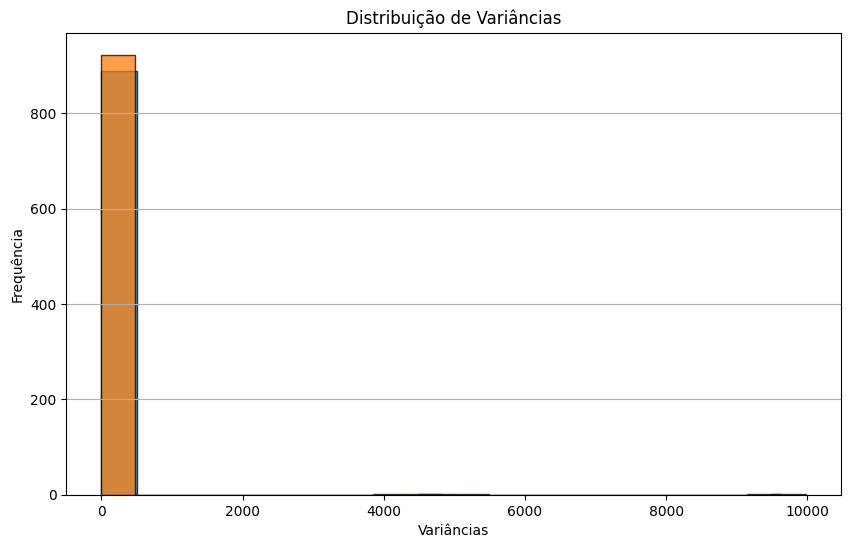

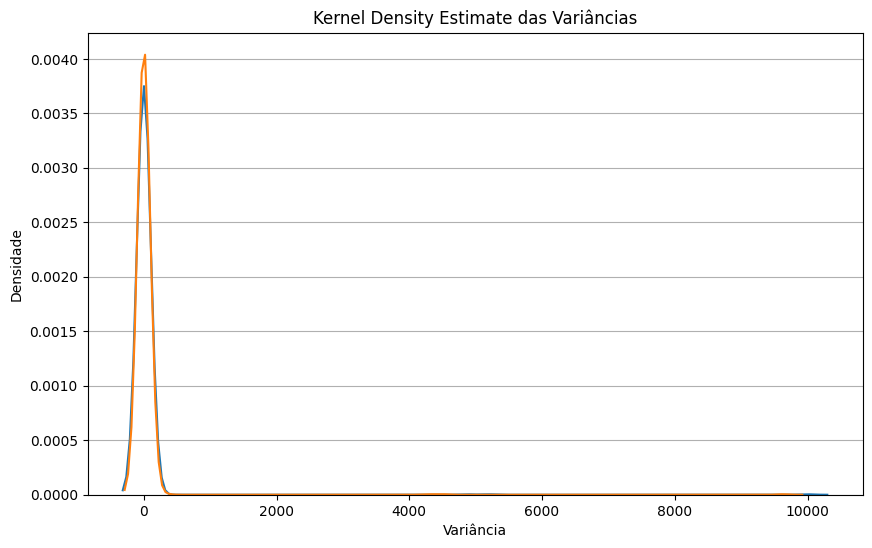

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_same_quantities["Preço Var"], bins=20, alpha=0.75, edgecolor='black')
plt.hist(df_same_quantities_2["Preço Var"], bins=20, alpha=0.75, edgecolor='black')

plt.title('Distribuição de Variâncias')
plt.xlabel('Variâncias')
plt.ylabel('Frequência')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 6))
sns.kdeplot(df_same_quantities["Preço Var"], bw_adjust=1)
sns.kdeplot(df_same_quantities_2["Preço Var"], bw_adjust=1)
plt.title('Kernel Density Estimate das Variâncias')
plt.xlabel('Variância')
plt.ylabel('Densidade')
plt.grid(axis='y')
plt.show()

In [ ]:
combinations_purchases.to_csv("resultado-1.csv", encoding='utf-8')
combinations_purchases_2.to_csv("resultado-2.csv", encoding='utf-8')
combinations_purchases_3.to_csv("resultado-3.csv", encoding='utf-8')

In [ ]:
df_same_quantities_3 = df_purchases_sales_agg_3[df_purchases_sales_agg_3['Qtd. Compra'] == df_purchases_sales_agg_3['Qtd. Venda']]
display(df_same_quantities_3)

,Cód. Cliente,Dt. Operação,Cód. Corretora,Cód. Título,Chave,Qtd. Compra,Valor Líquido Compra,Preço_x,Preço Var,index,Tipo Operação,Qtd. Venda,Preço_y,Valor Líquido Venda,Vencimento,Tipo,DI


In [ ]:
profits_3, ratios_3 = calculate_profit(df_same_quantities_3)
print(profits_3)
print(ratios_3)

[]
[]


#Análise exploratória

In [ ]:
import pandas as pd

# Supondo que você já tenha os dados em um DataFrame chamado df_compras

# Converter a coluna 'Dt. Operação' para o tipo datetime
df_compras_2022['Dt. Operação'] = pd.to_datetime(df_compras_2022['Dt. Operação'])

# Calcular a soma total de quantidades compradas por dia
soma_por_dia = df_compras_2022.groupby('Dt. Operação')['Quantidade'].sum()

# Encontrar o dia com a maior soma total de quantidades compradas
dia_maior_soma = soma_por_dia.idxmax()
maior_soma = soma_por_dia.max()

# Filtrar os dados para incluir apenas as compras do dia com a maior soma
compras_dia_maior_soma = df_compras_2022[df_compras_2022['Dt. Operação'] == dia_maior_soma]

# Agrupar as compras por código de título e calcular a quantidade total para cada título
combinacoes_por_titulo = compras_dia_maior_soma.groupby('Cód. Título')['Quantidade'].sum().reset_index()

# Exibir o dia com a maior soma total de quantidades compradas
print(f'Dia com a maior soma de compras: {dia_maior_soma}')
print(f'Total de compras neste dia: {maior_soma}')

# Exibir as combinações de títulos e suas quantidades correspondentes para este dia
print('\nCombinações de títulos e suas quantidades correspondentes:')
print(combinacoes_por_titulo)

Dia com a maior soma de compras: 2022-11-28 00:00:00
Total de compras neste dia: 596370171.0

Combinações de títulos e suas quantidades correspondentes:
    Cód. Título  Quantidade
0         AALR3     11081.0
1         AERI3   5435051.0
2         AFLT3    780092.0
3         AGXY3   1433983.0
4         AHEB3    535392.0
..          ...         ...
160       USIM3   3215719.0
161       VITT3   1651823.0
162       VIVA3     70248.0
163       VVAR3   1115940.0
164       VVEO3   1324266.0

[165 rows x 2 columns]


<ipython-input-8-57d790a20b81>:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_compras_2022['Dt. Operação'] = pd.to_datetime(df_compras_2022['Dt. Operação'])


In [ ]:
import pandas as pd

# Supondo que você já tenha os dados em um DataFrame chamado df_compras

# Calcular a soma total de quantidades de títulos compradas por cliente
soma_por_cliente = df_compras_2022.groupby('Cód. Cliente')['Quantidade'].sum()

# Identificar o cliente com a maior soma total de quantidades de títulos
cliente_maior_combinacao = soma_por_cliente.idxmax()
maior_combinacao = soma_por_cliente.max()

# Filtrar os dados para incluir apenas as compras do cliente com a maior soma
compras_cliente_maior_combinacao = df_compras_2022[df_compras_2022['Cód. Cliente'] == cliente_maior_combinacao]

# Agrupar as compras do cliente por código de título e calcular a quantidade total para cada título
combinacoes_por_titulo = compras_cliente_maior_combinacao.groupby('Cód. Título')['Quantidade'].sum().reset_index()

# Exibir o cliente com a maior combinação de títulos e as combinações de títulos e suas quantidades correspondentes
print(f'Cliente com a maior combinação de títulos: {cliente_maior_combinacao}')
print(f'Total de títulos comprados pelo cliente: {maior_combinacao}')

print('\nCombinações de títulos e suas quantidades correspondentes para o cliente:')
print(combinacoes_por_titulo)


Cliente com a maior combinação de títulos: Cliente 37
Total de títulos comprados pelo cliente: 3054169076.0

Combinações de títulos e suas quantidades correspondentes para o cliente:
    Cód. Título  Quantidade
0         AALR3   1252180.0
1         ABCB4    823096.0
2         ABEV3   1539313.0
3         AFLT3   8041595.0
4         AGXY3   6613507.0
..          ...         ...
452       WHRL4   2717960.0
453       WIZS3   8297213.0
454       WLMM3    807927.0
455       WLMM4    312768.0
456       YDUQ3   2277376.0

[457 rows x 2 columns]


In [ ]:
import pandas as pd

# Supondo que você já tenha os dados em um DataFrame chamado df_compras

# Calcular a soma total de quantidades de ações compradas por cliente
soma_por_cliente = df_compras_2022.groupby('Cód. Cliente')['Quantidade'].sum()

# Identificar o cliente com a menor soma total de quantidades de ações
cliente_menor_combinacao = soma_por_cliente.idxmin()

# Filtrar os dados para incluir apenas as compras do cliente com a menor soma
compras_cliente_menor_combinacao = df_compras_2022[df_compras_2022['Cód. Cliente'] == cliente_menor_combinacao]

# Agrupar as compras do cliente por código de título e calcular a quantidade total para cada título
combinacoes_por_titulo = compras_cliente_menor_combinacao.groupby('Cód. Título')['Quantidade'].sum().reset_index()

# Exibir o cliente com a menor combinação de ações e as combinações de títulos e suas quantidades correspondentes
print(f'Cliente com a menor combinação de ações: {cliente_menor_combinacao}')
print('\nCombinações de títulos e suas quantidades correspondentes para o cliente:')
print(combinacoes_por_titulo)

# Calcular a quantidade total de títulos comprados pelo cliente com a menor soma
total_titulos_comprados = combinacoes_por_titulo['Quantidade'].sum()
print(f'\nTotal de títulos comprados pelo cliente com a menor combinação: {total_titulos_comprados}')

Cliente com a menor combinação de ações: Cliente 100

Combinações de títulos e suas quantidades correspondentes para o cliente:
    Cód. Título  Quantidade
0         AALR3     54992.0
1         ABCB4    113462.0
2         AERI3    159386.0
3         AESB3    153846.0
4         AFLT3    104185.0
..          ...         ...
452       WHRL4     97845.0
453       WIZS3     95818.0
454       WLMM3     69238.0
455       WLMM4      3012.0
456       YDUQ3      1187.0

[457 rows x 2 columns]

Total de títulos comprados pelo cliente com a menor combinação: 62255266.0


In [ ]:
import pandas as pd

# Supondo que você já tenha os dados em um DataFrame chamado df_compras

# Calcular a soma total de quantidades de cada título comprado
soma_por_titulo = df_compras_2022.groupby('Cód. Título')['Quantidade'].sum()

# Identificar o título com a maior soma total de quantidades
titulo_maior_combinacao = soma_por_titulo.idxmax()
maior_combinacao = soma_por_titulo.max()

# Filtrar os dados para incluir apenas as compras do título com a maior soma
compras_titulo_maior_combinacao = df_compras_2022[df_compras_2022['Cód. Título'] == titulo_maior_combinacao]

# Agrupar as compras do título por código do cliente e calcular a quantidade total para cada cliente
combinacoes_por_cliente = compras_titulo_maior_combinacao.groupby('Cód. Cliente')['Quantidade'].sum().reset_index()

# Exibir o título com a maior combinação de compras e as combinações de clientes e suas quantidades correspondentes
print(f'Título com a maior combinação de compras: {titulo_maior_combinacao}')
print(f'Total de unidades compradas do título: {maior_combinacao}')

print('\nCombinações de clientes e suas quantidades correspondentes para o título:')
print(combinacoes_por_cliente)

Título com a maior combinação de compras: INEP3
Total de unidades compradas do título: 1366638099.0

Combinações de clientes e suas quantidades correspondentes para o título:
   Cód. Cliente   Quantidade
0    Cliente 10    1198944.0
1   Cliente 101    1543155.0
2    Cliente 11     398567.0
3    Cliente 12   30248033.0
4    Cliente 14   88690150.0
5    Cliente 15   58482984.0
6    Cliente 16   11450792.0
7    Cliente 18   18973718.0
8    Cliente 19   71685356.0
9     Cliente 2   25128753.0
10   Cliente 20   48089578.0
11   Cliente 21   89171641.0
12   Cliente 24   99216781.0
13   Cliente 25   15288474.0
14   Cliente 26   42143885.0
15   Cliente 27   24408674.0
16   Cliente 28  110365521.0
17   Cliente 29   68029740.0
18    Cliente 3  151405678.0
19   Cliente 31   19101245.0
20   Cliente 32    8090890.0
21   Cliente 33   63137136.0
22   Cliente 34   71653631.0
23   Cliente 35   72743576.0
24   Cliente 36   31267359.0
25   Cliente 37  134647519.0
26   Cliente 38   10076319.0


In [ ]:
import pandas as pd

# Supondo que você já tenha os dados em um DataFrame chamado df_compras

# Calcular a soma total de quantidades de cada título comprado
soma_por_titulo = df_compras_2022.groupby('Cód. Título')['Quantidade'].sum()

# Identificar o título com a menor soma total de quantidades
titulo_menos_comprado = soma_por_titulo.idxmin()
menor_quantidade = soma_por_titulo.min()

# Filtrar os dados para incluir apenas as compras do título com a menor soma
compras_titulo_menos_comprado = df_compras_2022[df_compras_2022['Cód. Título'] == titulo_menos_comprado]

# Identificar os clientes que compraram o título menos comprado
clientes_titulo_menos_comprado = compras_titulo_menos_comprado['Cód. Cliente'].unique()

# Exibir o título menos comprado, a quantidade correspondente e os clientes que compraram este título
print(f'Título menos comprado: {titulo_menos_comprado}')
print(f'Quantidade total comprada deste título: {menor_quantidade}')
print('\nClientes que compraram este título:')
print(clientes_titulo_menos_comprado)


Título menos comprado: APTI4
Quantidade total comprada deste título: 313310.0

Clientes que compraram este título:
['Cliente 10' 'Cliente 100' 'Cliente 101' 'Cliente 11' 'Cliente 12'
 'Cliente 13' 'Cliente 14' 'Cliente 15' 'Cliente 16' 'Cliente 17'
 'Cliente 18' 'Cliente 19' 'Cliente 2' 'Cliente 20' 'Cliente 21'
 'Cliente 22' 'Cliente 23' 'Cliente 24' 'Cliente 25' 'Cliente 26'
 'Cliente 27' 'Cliente 28' 'Cliente 29' 'Cliente 3' 'Cliente 30'
 'Cliente 31' 'Cliente 32' 'Cliente 34' 'Cliente 35' 'Cliente 36'
 'Cliente 37' 'Cliente 38' 'Cliente 39']


In [ ]:
import pandas as pd

# Supondo que você já tenha os dados em um DataFrame chamado df_compras

# Converter a coluna 'Dt. Operação' para o tipo datetime
df_compras_2022['Dt. Operação'] = pd.to_datetime(df_compras_2022['Dt. Operação'])

# Calcular a soma total de quantidades compradas por dia
soma_por_dia = df_compras_2022.groupby('Dt. Operação')['Quantidade'].sum()

# Encontrar o dia com a menor soma total de quantidades compradas
dia_menor_soma = soma_por_dia.idxmin()
menor_soma = soma_por_dia.min()

# Filtrar os dados para incluir apenas as compras do dia com a menor soma
compras_dia_menor_soma = df_compras_2022[df_compras_2022['Dt. Operação'] == dia_menor_soma]

# Agrupar as compras por código de título e calcular a quantidade total para cada título
combinacoes_por_titulo = compras_dia_menor_soma.groupby('Cód. Título')['Quantidade'].sum().reset_index()

# Exibir o dia com a menor soma total de quantidades compradas
print(f'Dia com a menor soma de compras: {dia_menor_soma}')
print(f'Total de compras neste dia: {menor_soma}')

# Exibir as combinações de títulos e suas quantidades correspondentes para este dia
print('\nCombinações de títulos e suas quantidades correspondentes:')
print(combinacoes_por_titulo)

Dia com a menor soma de compras: 2022-08-09 00:00:00
Total de compras neste dia: 235998582.0

Combinações de títulos e suas quantidades correspondentes:
    Cód. Título  Quantidade
0         AALR3    950160.0
1         AGRO3     20777.0
2         AGXY3   1167456.0
3         AHEB5    663250.0
4         ALPA3   1370819.0
..          ...         ...
134       TEKA3   1238295.0
135       TELB3    878924.0
136       TKNO3      7351.0
137       TRPL3     30600.0
138       UNIP6     13825.0

[139 rows x 2 columns]


In [ ]:
coluna_corretora='Cód. Corretora'
valores_unicos = df_compras_2022[coluna_corretora].unique()

num_valores_unicos=len(valores_unicos)

print("Valores únicos na coluna '{}':".format(coluna_corretora))
print(valores_unicos)
print("Número de valores únicos: ", num_valores_unicos)

Valores únicos na coluna 'Cód. Corretora':
['STDE' 'AGOR' 'TERR' 'MIRA' 'ORAM' 'PACT' 'CONC' 'INDU' 'BRAD' 'VITR'
 'FUTU' 'LEV ' 'PACC' 'CSUI' 'SAFR' 'CAPM' 'FLOW' 'PLAN' 'XPIN' 'ITAU'
 'ATIV']
Número de valores únicos:  21


In [ ]:
coluna_corretora_vendas='Cód. Corretora'
valores_unicos_vendas = df_vendas_2022[coluna_corretora_vendas].unique()

num_valores_unicos_vendas=len(valores_unicos_vendas)

print("Valores únicos na coluna '{}':".format(coluna_corretora_vendas))
print(valores_unicos_vendas)
print("Número de valores únicos: ", num_valores_unicos_vendas)

Valores únicos na coluna 'Cód. Corretora':
['STDE' 'AGOR' 'TERR' 'MIRA' 'ORAM' 'PACT' 'CONC' 'INDU' 'BRAD' 'VITR'
 'FUTU' 'LEV ' 'PACC' 'CSUI' 'SAFR' 'CAPM' 'FLOW' 'PLAN' 'XPIN' 'ITAU'
 'ATIV']
Número de valores únicos:  21


In [ ]:
coluna_cliente='Cód. Cliente'
valores_unicos_cliente = df_compras_2022[coluna_cliente].unique()

num_valores_unicos_cliente=len(valores_unicos)

print("Valores únicos na coluna '{}':".format(coluna_cliente))
print(valores_unicos_cliente)
print("Número de valores únicos: ", num_valores_unicos_cliente)

Valores únicos na coluna 'Cód. Cliente':
['Cliente 10' 'Cliente 100' 'Cliente 101' 'Cliente 11' 'Cliente 12'
 'Cliente 13' 'Cliente 14' 'Cliente 15' 'Cliente 16' 'Cliente 17'
 'Cliente 18' 'Cliente 19' 'Cliente 2' 'Cliente 20' 'Cliente 21'
 'Cliente 22' 'Cliente 23' 'Cliente 24' 'Cliente 25' 'Cliente 26'
 'Cliente 27' 'Cliente 28' 'Cliente 29' 'Cliente 3' 'Cliente 30'
 'Cliente 31' 'Cliente 32' 'Cliente 33' 'Cliente 34' 'Cliente 35'
 'Cliente 36' 'Cliente 37' 'Cliente 38' 'Cliente 39']
Número de valores únicos:  21


In [ ]:
coluna_cliente_vendas='Cód. Cliente'
valores_unicos_cliente_vendas = df_vendas_2022[coluna_cliente_vendas].unique()

num_valores_unicos_cliente_vendas=len(valores_unicos_cliente_vendas)

print("Valores únicos na coluna '{}':".format(coluna_cliente_vendas))
print(valores_unicos_cliente_vendas)
print("Número de valores únicos: ", num_valores_unicos_cliente_vendas)

Valores únicos na coluna 'Cód. Cliente':
['Cliente 10' 'Cliente 100' 'Cliente 101' 'Cliente 11']
Número de valores únicos:  4


In [ ]:
coluna_titulos='Cód. Título'
valores_unicos_titulos = df_compras_2022[coluna_titulos].unique()

num_valores_unicos_titulos=len(valores_unicos_titulos)

print("Valores únicos na coluna '{}':".format(coluna_titulos))
print(valores_unicos_titulos)
print("Número de valores únicos: ", num_valores_unicos_titulos)

Valores únicos na coluna 'Cód. Título':
['ABCB4' 'ABEV3' 'AERI3' 'AESB3' 'AFLT3' 'AGXY3' 'AHEB3' 'AHEB5' 'AHEB6'
 'ALLD3' 'ALPA3' 'ALPA4' 'ALPK3' 'ALSO3' 'ALUP4' 'AMAR3' 'AMBP3' 'AMER3'
 'ANIM3' 'APER3' 'APTI4' 'ARML3' 'ARZZ3' 'ASAI3' 'ATMP3' 'AVLL3' 'AZEV3'
 'AZEV4' 'AZUL4' 'B3SA3' 'BAHI3' 'BALM3' 'BALM4' 'BAZA3' 'BBAS3' 'BBDC3'
 'BBDC4' 'BBSE3' 'BDLL3' 'BDLL4' 'BEEF3' 'BEES3' 'BEES4' 'BGIP3' 'BGIP4'
 'BIDI4' 'BIOM3' 'BKBR3' 'BLAU3' 'BLUT3' 'BMEB3' 'BMGB4' 'BMIN3' 'BMIN4'
 'BMKS3' 'BMOB3' 'BNBR3' 'BOAS3' 'BOBR4' 'BPAC3' 'BPAN4' 'BPAR3' 'BRAP3'
 'BRAP4' 'BRDT3' 'BRFS3' 'BRGE11' 'BRGE12' 'BRGE3' 'BRGE5' 'BRGE6' 'BRGE8'
 'BRIV3' 'BRIV4' 'BRKM5' 'BRKM6' 'BRPR3' 'BRSR3' 'BRSR5' 'BRSR6' 'BSEV3'
 'BSLI3' 'BTOW3' 'BTTL3' 'CALI3' 'CAMB3' 'CAML3' 'CARD3' 'CASH3' 'CASN3'
 'CASN4' 'CBAV3' 'CBEE3' 'CCPR3' 'CCRO3' 'CEAB3' 'CEBR3' 'CEBR5' 'CEDO3'
 'CEDO4' 'CEEB3' 'CEEB5' 'CEED3' 'CEED4' 'CEGR3' 'CEPE3' 'CEPE5' 'CEPE6'
 'CESP3' 'CESP6' 'CGAS3' 'CGAS5' 'CGRA3' 'CGRA4' 'CIEL3' 'CLSA3' 'CLSC3'
 'CLSC4' 

In [ ]:
coluna_titulos_vendas='Cód. Título'
valores_unicos_titulos_vendas = df_vendas_2022[coluna_titulos_vendas].unique()

num_valores_unicos_titulos_vendas=len(valores_unicos_titulos_vendas)

print("Valores únicos na coluna '{}':".format(coluna_titulos_vendas))
print(valores_unicos_titulos_vendas)
print("Número de valores únicos: ", num_valores_unicos_titulos_vendas)

Valores únicos na coluna 'Cód. Título':
['ABCB4' 'ABEV3' 'AERI3' 'AESB3' 'AFLT3' 'AGXY3' 'AHEB3' 'AHEB5' 'AHEB6'
 'ALLD3' 'ALPA3' 'ALPA4' 'ALPK3' 'ALSO3' 'ALUP4' 'AMAR3' 'AMBP3' 'AMER3'
 'ANIM3' 'APER3' 'APTI4' 'ARML3' 'ARZZ3' 'ASAI3' 'ATMP3' 'AVLL3' 'AZEV3'
 'AZEV4' 'AZUL4' 'B3SA3' 'BAHI3' 'BALM3' 'BALM4' 'BAZA3' 'BBAS3' 'BBDC3'
 'BBDC4' 'BBSE3' 'BDLL3' 'BDLL4' 'BEEF3' 'BEES3' 'BEES4' 'BGIP3' 'BGIP4'
 'BIDI4' 'BIOM3' 'BKBR3' 'BLAU3' 'BLUT3' 'BMEB3' 'BMGB4' 'BMIN3' 'BMIN4'
 'BMKS3' 'BMOB3' 'BNBR3' 'BOAS3' 'BOBR4' 'BPAC3' 'BPAN4' 'BPAR3' 'BRAP3'
 'BRAP4' 'BRDT3' 'BRFS3' 'BRGE11' 'BRGE12' 'BRGE3' 'BRGE5' 'BRGE6' 'BRGE8'
 'BRIV3' 'BRIV4' 'BRKM5' 'BRKM6' 'BRPR3' 'BRSR3' 'BRSR5' 'BRSR6' 'BSEV3'
 'BSLI3' 'BTOW3' 'BTTL3' 'CALI3' 'CAMB3' 'CAML3' 'CARD3' 'CASH3' 'CASN3'
 'CASN4' 'CBAV3' 'CBEE3' 'CCPR3' 'CCRO3' 'CEAB3' 'CEBR3' 'CEBR5' 'CEDO3'
 'CEDO4' 'CEEB3' 'CEEB5' 'CEED3' 'CEED4' 'CEGR3' 'CEPE3' 'CEPE5' 'CEPE6'
 'CESP3' 'CESP6' 'CGAS3' 'CGAS5' 'CGRA3' 'CGRA4' 'CIEL3' 'CLSA3' 'CLSC3'
 'CLSC4' 

In [ ]:
# Agrupar os dados por título e somar as quantidades de ações para cada título
acoes_por_titulo = df_compras_2022.groupby('Cód. Título')['Quantidade'].sum()

# Exibir os títulos com as quantidades de ações correspondentes
print(acoes_por_titulo)

Cód. Título
AALR3     55617975.0
ABCB4     66603787.0
ABEV3     70912962.0
AERI3    373189113.0
AESB3    116162424.0
            ...     
WHRL4    191556989.0
WIZS3    140036190.0
WLMM3     43154912.0
WLMM4     44491129.0
YDUQ3     67649310.0
Name: Quantidade, Length: 505, dtype: float64


In [ ]:
# Agrupar os dados por título e somar as quantidades de ações para cada título
acoes_por_titulo_vendidos = df_vendas_2022.groupby('Cód. Título')['Quantidade'].sum()

# Exibir os títulos com as quantidades de ações correspondentes
print(acoes_por_titulo_vendidos)

Cód. Título
AALR3     85473.0
ABCB4    116809.0
ABEV3     40812.0
AERI3    569969.0
AESB3    280752.0
           ...   
WHRL4    517795.0
WIZS3    100881.0
WLMM3     62980.0
WLMM4     48764.0
YDUQ3     38562.0
Name: Quantidade, Length: 504, dtype: float64


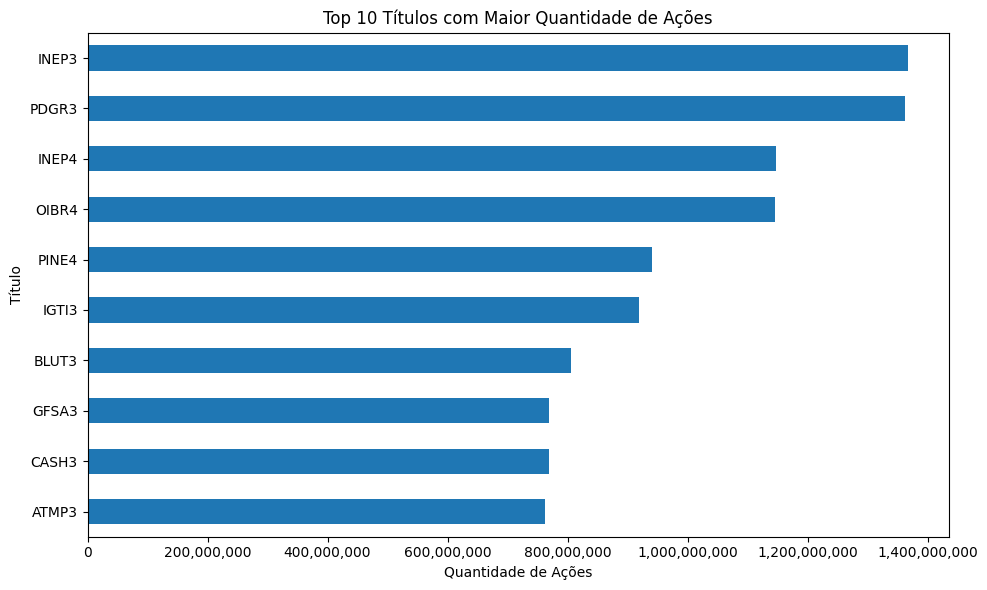

In [ ]:
import matplotlib.pyplot as plt

# Selecionar os 10 títulos com as maiores quantidades de ações
top_10_acoes_por_titulo = acoes_por_titulo.nlargest(10)

# Criar um gráfico de barras
plt.figure(figsize=(10, 6))
top_10_acoes_por_titulo.sort_values().plot(kind='barh')

# Definir o formato do rótulo do eixo x como números inteiros
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.title('Top 10 Títulos com Maior Quantidade de Ações')
plt.xlabel('Quantidade de Ações')
plt.ylabel('Título')
plt.tight_layout()
plt.show()

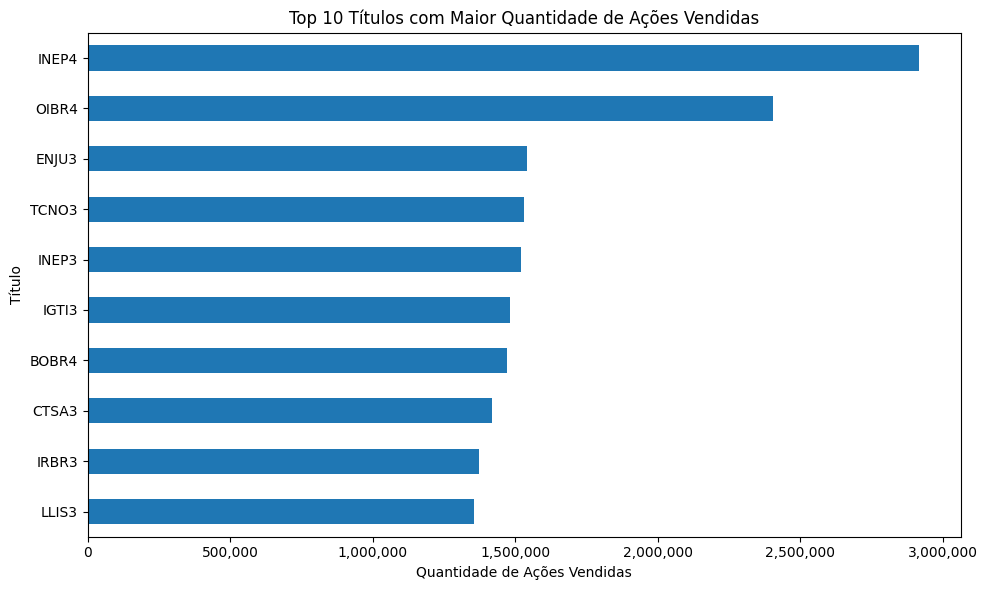

In [ ]:
import matplotlib.pyplot as plt

# Selecionar os 10 títulos com as maiores quantidades de ações
top_10_acoes_por_titulo_vendidos = acoes_por_titulo_vendidos.nlargest(10)

# Criar um gráfico de barras
plt.figure(figsize=(10, 6))
top_10_acoes_por_titulo_vendidos.sort_values().plot(kind='barh')

# Definir o formato do rótulo do eixo x como números inteiros
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.title('Top 10 Títulos com Maior Quantidade de Ações Vendidas')
plt.xlabel('Quantidade de Ações Vendidas')
plt.ylabel('Título')
plt.tight_layout()
plt.show()

In [ ]:
# Agrupar os dados por título e somar as quantidades de ações para cada título
valor_por_titulo = df_compras_2022
# Exibir os títulos com as quantidades de ações correspondentes
print(valor_por_titulo)

       Cód. Cliente Dt. Operação Tipo Operação Cód. Título Cód. Corretora  \
0        Cliente 10   2022-01-04             C       ABCB4           STDE   
1        Cliente 10   2022-01-04             C       ABCB4           STDE   
2        Cliente 10   2022-01-04             C       ABCB4           STDE   
3        Cliente 10   2022-01-04             C       ABCB4           STDE   
4        Cliente 10   2022-01-04             C       ABCB4           STDE   
...             ...          ...           ...         ...            ...   
565314   Cliente 39   2022-06-15             C       BNBR3           ATIV   
565315   Cliente 39   2022-06-15             C       BNBR3           ATIV   
565316   Cliente 39   2022-06-15             C       BNBR3           ATIV   
565317   Cliente 39   2022-06-15             C       BNBR3           ATIV   
565318   Cliente 39   2022-06-15             C       BNBR3           ATIV   

        Quantidade      Preço  Valor Líquido Dt. Liquidação Tipo  
0       

In [ ]:
# Agrupar os dados por título e somar as quantidades de ações para cada título
valor_por_titulo_vendido = df_vendas_2022.groupby('Cód. Título')['Valor Líquido'].sum()

# Exibir os títulos com as quantidades de ações correspondentes
print(valor_por_titulo_vendido)

Cód. Título
AALR3    1.747240e+06
ABCB4    1.954011e+06
ABEV3    6.082806e+05
AERI3    1.387403e+06
AESB3    3.080124e+06
             ...     
WHRL4    3.061238e+06
WIZS3    8.724612e+05
WLMM3    1.539843e+06
WLMM4    1.676579e+06
YDUQ3    6.124542e+05
Name: Valor Líquido, Length: 504, dtype: float64


In [ ]:
# Selecionar os 10 títulos com as maiores quantidades de ações
top_10_valor_por_titulo = valor_por_titulo.nlargest(10)

# Criar um gráfico de barras
plt.figure(figsize=(10, 6))
top_10_valor_por_titulo.sort_values().plot(kind='barh')

# Definir o formato do rótulo do eixo x como números inteiros
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.title('Top 10 Títulos com Maior Valor Líquido de Ações')
plt.xlabel('Valor Líquido')
plt.ylabel('Título')
plt.tight_layout()
plt.show()

TypeError: DataFrame.nlargest() missing 1 required positional argument: 'columns'

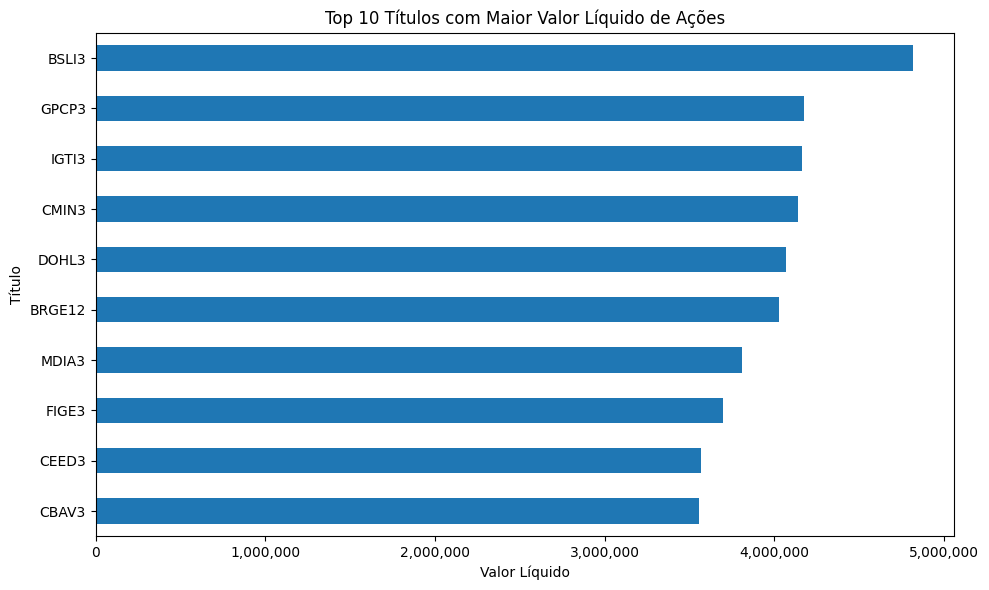

In [ ]:
# Selecionar os 10 títulos com as maiores quantidades de ações
top_10_valor_por_titulo_vendido = valor_por_titulo_vendido.nlargest(10)

# Criar um gráfico de barras
plt.figure(figsize=(10, 6))
top_10_valor_por_titulo_vendido.sort_values().plot(kind='barh')

# Definir o formato do rótulo do eixo x como números inteiros
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.title('Top 10 Títulos com Maior Valor Líquido de Ações')
plt.xlabel('Valor Líquido')
plt.ylabel('Título')
plt.tight_layout()
plt.show()

In [ ]:
df_sorted = df_compras_2022.sort_values(by='Dt. Liquidação')

coluna_vencimento='Dt. Liquidação'
valores_unicos_vencimento = df_compras_2022[coluna_vencimento].unique()


num_valores_unicos_vencimento=len(valores_unicos_vencimento)

print("Valores únicos na coluna '{}':".format(coluna_vencimento))
print(valores_unicos_vencimento)
print("Número de valores únicos: ", num_valores_unicos_vencimento)

Valores únicos na coluna 'Dt. Liquidação':
['01/04/2022']
Número de valores únicos:  1


In [ ]:
# Contar o número de aparições e repetições de cada atributo em uma coluna
contagem_valores_clientes = df_compras_2022['Cód. Cliente'].value_counts()

# Exibir a contagem de valores
print(contagem_valores_clientes)

Cliente 23     17808
Cliente 10     17722
Cliente 36     17718
Cliente 3      17670
Cliente 15     17664
Cliente 35     17596
Cliente 29     17468
Cliente 30     17437
Cliente 17     17434
Cliente 32     17413
Cliente 2      17400
Cliente 14     17339
Cliente 18     17294
Cliente 37     17213
Cliente 21     17212
Cliente 34     17208
Cliente 19     17148
Cliente 26     17074
Cliente 33     17016
Cliente 25     16980
Cliente 20     16902
Cliente 13     16774
Cliente 101    16741
Cliente 100    16687
Cliente 24     16680
Cliente 38     16660
Cliente 28     16603
Cliente 11     16569
Cliente 27     16540
Cliente 12     16362
Cliente 31     16248
Cliente 16     16199
Cliente 22     16192
Cliente 39      2348
Name: Cód. Cliente, dtype: int64


In [ ]:
# Contar o número de aparições e repetições de cada atributo em uma coluna
contagem_valores_clientes_vendas = df_vendas_2022['Cód. Cliente'].value_counts()

# Exibir a contagem de valores
print(contagem_valores_clientes_vendas)

Cliente 10     1232
Cliente 101    1211
Cliente 100    1201
Cliente 11      782
Name: Cód. Cliente, dtype: int64


In [ ]:
df_compras_2022_datetime = df_compras_2022.copy()
df_vendas_2022_datetime = df_vendas_2022.copy()
df_compras_2022_datetime['Dt. Liquidação'] = pd.to_datetime(df_compras_2022_datetime['Dt. Liquidação'])
df_vendas_2022_datetime['Vencimento'] = pd.to_datetime(df_vendas_2022_datetime['Vencimento'])


In [ ]:



# Agrupar os dados por mês e contar o número de ações em cada mês
acoes_por_mes = df_compras_2022_datetime.groupby(df_compras_2022_datetime['Dt. Liquidação'].dt.month)['Quantidade'].count()

# Criar um gráfico de linhas
plt.figure(figsize=(10, 6))
acoes_por_mes.plot(marker='o', linestyle='-')
plt.title('Quantidade de Ações por Mês em 2022')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Ações')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Filtrar os dados para o ano de 2023
df_2022= df_vendas_2022[df_vendas_2022_datetime['Vencimento'].dt.year == 2022]

# Agrupar os dados por mês e contar o número de ações em cada mês
acoes_por_mes_vendas = df_2022.groupby(df_2022['Vencimento'].dt.month)['Quantidade'].count()

# Criar um gráfico de linhas
plt.figure(figsize=(10, 6))
acoes_por_mes_vendas.plot(marker='o', linestyle='-')
plt.title('Quantidade de Ações por Mês em 2023')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Ações')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(True)
plt.tight_layout()
plt.show()

AttributeError: Can only use .dt accessor with datetimelike values

<ipython-input-44-8046f912c866>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  valor_por_cliente_por_dia = df_compras_2022.groupby(['Cód. Cliente']).sum()['Valor Líquido']


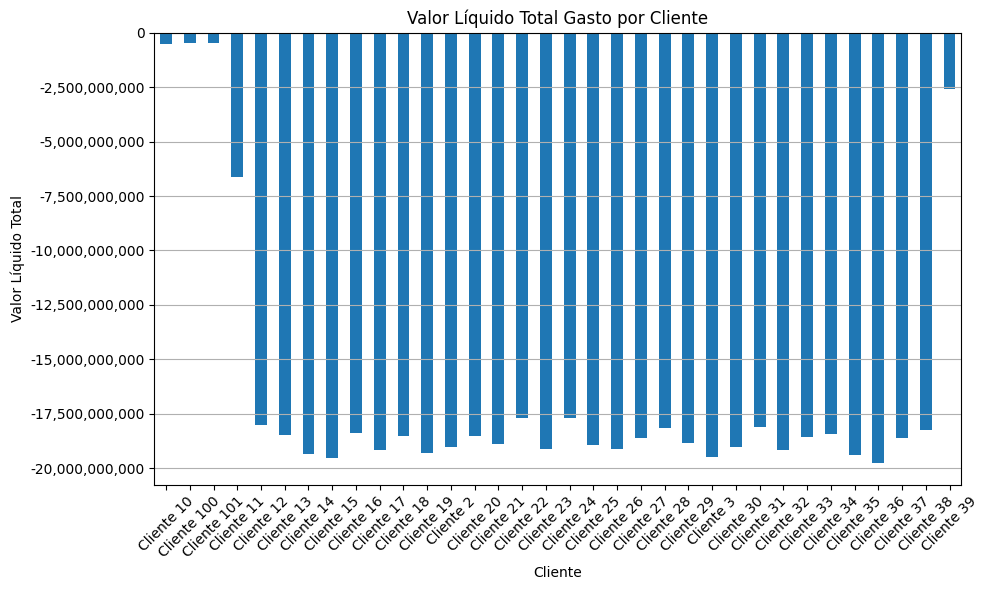

In [ ]:
import matplotlib.pyplot as plt

# Calcular o valor líquido total gasto por cada cliente em cada dia
valor_por_cliente_por_dia = df_compras_2022.groupby(['Cód. Cliente']).sum()['Valor Líquido']

# Somar o valor líquido total gasto por cada cliente em todos os dias
valor_total_por_cliente = valor_por_cliente_por_dia.groupby('Cód. Cliente').sum()

# Construir um gráfico de barras para mostrar os valores totais por cliente
plt.figure(figsize=(10, 6))
valor_total_por_cliente.plot(kind='bar')
plt.title('Valor Líquido Total Gasto por Cliente')
plt.xlabel('Cliente')
plt.ylabel('Valor Líquido Total')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Configurar os rótulos do eixo y para exibir números inteiros
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.tight_layout()
plt.show()


<ipython-input-45-c7500bee6337>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  valor_por_cliente_por_dia_vendas = df_vendas_2022.groupby(['Cód. Cliente']).sum()['Valor Líquido']


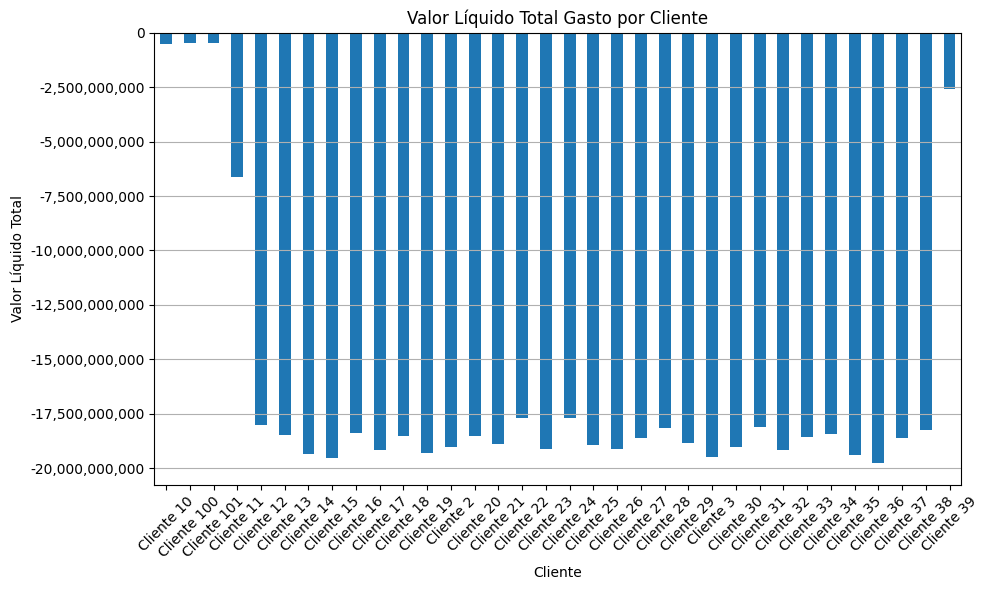

In [ ]:
import matplotlib.pyplot as plt

# Calcular o valor líquido total gasto por cada cliente em cada dia
valor_por_cliente_por_dia_vendas = df_vendas_2022.groupby(['Cód. Cliente']).sum()['Valor Líquido']

# Somar o valor líquido total gasto por cada cliente em todos os dias
valor_total_por_cliente_vendas = valor_por_cliente_por_dia_vendas.groupby('Cód. Cliente').sum()

# Construir um gráfico de barras para mostrar os valores totais por cliente
plt.figure(figsize=(10, 6))
valor_total_por_cliente.plot(kind='bar')
plt.title('Valor Líquido Total Gasto por Cliente')
plt.xlabel('Cliente')
plt.ylabel('Valor Líquido Total')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Configurar os rótulos do eixo y para exibir números inteiros
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.tight_layout()
plt.show()


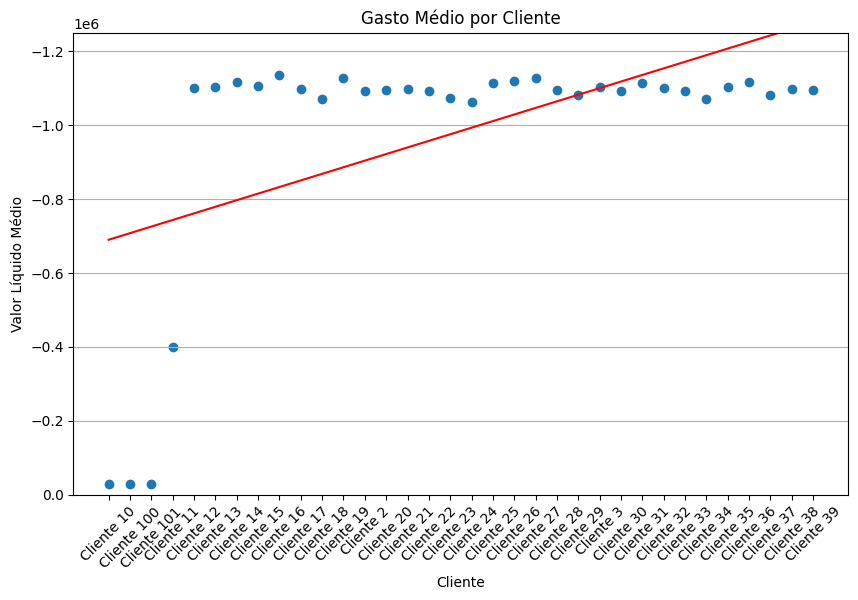

In [ ]:
import numpy as np

gasto_medio_cliente = df_compras_2022.groupby('Cód. Cliente')['Valor Líquido'].mean().reset_index()

# Setting the figure size for the plot
plt.figure(figsize=(10, 6))

# Plotting the mean spending per client
plt.scatter(gasto_medio_cliente['Cód. Cliente'], gasto_medio_cliente['Valor Líquido'])

x = np.arange(len(gasto_medio_cliente))  # This creates a numerical array for x-values if 'Cód. Cliente' is categorical
y = gasto_medio_cliente['Valor Líquido']

# Calculate the line of best fit
m, b = np.polyfit(x, y, 1)

# Add the line of best fit over the scatterplot
plt.plot(gasto_medio_cliente['Cód. Cliente'], m*x + b, color='red')  # Trendline

# Setting the title and labels for the axes
plt.title('Gasto Médio por Cliente')
plt.xlabel('Cliente')
plt.ylabel('Valor Líquido Médio')

# Setting the y-axis to start from 0
plt.ylim([0, gasto_medio_cliente['Valor Líquido'].min() * 1.1])  # Extend the max to make the plot look better

# Rotating the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding grid lines along the y-axis for better readability
plt.grid(axis='y')

# Showing the plot
plt.show()


TypeError: expected x and y to have same length

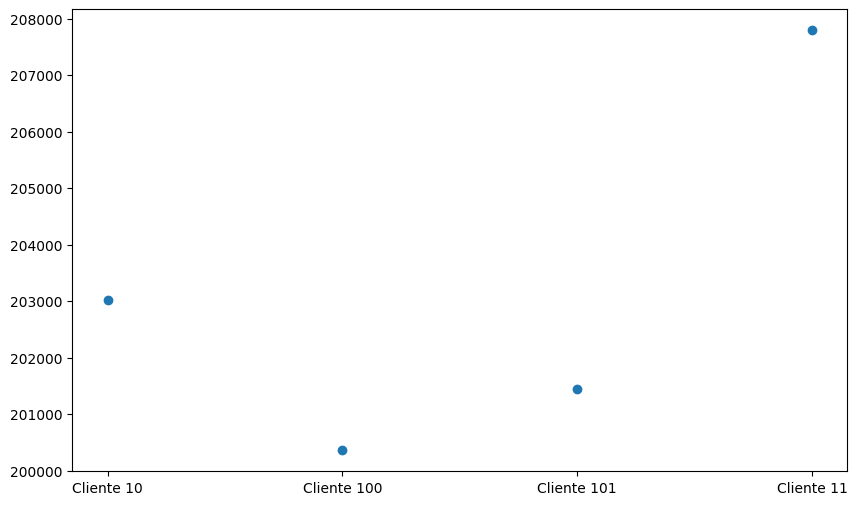

In [ ]:
import numpy as np

lucro_medio_cliente = df_vendas_2022.groupby('Cód. Cliente')['Valor Líquido'].mean().reset_index()

# Setting the figure size for the plot
plt.figure(figsize=(10, 6))

# Plotting the mean spending per client
plt.scatter(lucro_medio_cliente['Cód. Cliente'], lucro_medio_cliente['Valor Líquido'])

x = np.arange(len(gasto_medio_cliente))  # This creates a numerical array for x-values if 'Cód. Cliente' is categorical
y = lucro_medio_cliente['Valor Líquido']

# Calculate the line of best fit
m, b = np.polyfit(x, y, 1)

# Add the line of best fit over the scatterplot
plt.plot(lucro_medio_cliente['Cód. Cliente'], m*x + b, color='red')  # Trendline

# Setting the title and labels for the axes
plt.title('Lucro Médio por Cliente')
plt.xlabel('Cliente')
plt.ylabel('Valor Líquido Médio')

# Setting the y-axis to start from 0
plt.ylim([0, gasto_medio_cliente['Valor Líquido'].min() * 1.1])  # Extend the max to make the plot look better

# Rotating the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding grid lines along the y-axis for better readability
plt.grid(axis='y')

# Showing the plot
plt.show()

## Teste